**Etude de faisaibilité TEXTE**
-----------------
Ce notebook a objectif d'étudier la faisabilité des éléments de description textuelle des produits.


On procéde en 3 étapes :
- **Analyse et prétraitement nécessaires des données**
- **Vectorisation numérique des données par plusieurs méthodes** : TF-IDF, Word2Vec, GloVe, FastText, USE, BERT
- **Segmentation non supervisée de ces vecteurs**
- **Mesure de la similarité entre les segments et les catégories prédéfinies**


Nous pourrons comparer ces résultats à ceux de la partie vision avant de décider quelle méthode utiliser pour la partie de classification supervisée.

# Imports

In [30]:
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from gc import collect

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from tqdm import tqdm

from itertools import product
from collections import defaultdict

from gensim.models import KeyedVectors, Word2Vec
from huggingface_hub import hf_hub_download, hf_hub_url

In [5]:
# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

# **Chargement des données nettoyées**

In [6]:
text_df = pd.read_pickle('flipkart_cleaned.pkl')
text_df.drop(columns=['image'], inplace=True)
print(text_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   product_name  1050 non-null   object  
 1   description   1050 non-null   object  
 2   class         1050 non-null   category
dtypes: category(1), object(2)
memory usage: 17.6+ KB
None


# **Analyse et prétraitement des données**

## Statistiques descriptives sur les champs textuels

**Calcul des statistiques descriptives sur le nombre de caractères des champs textuels:**

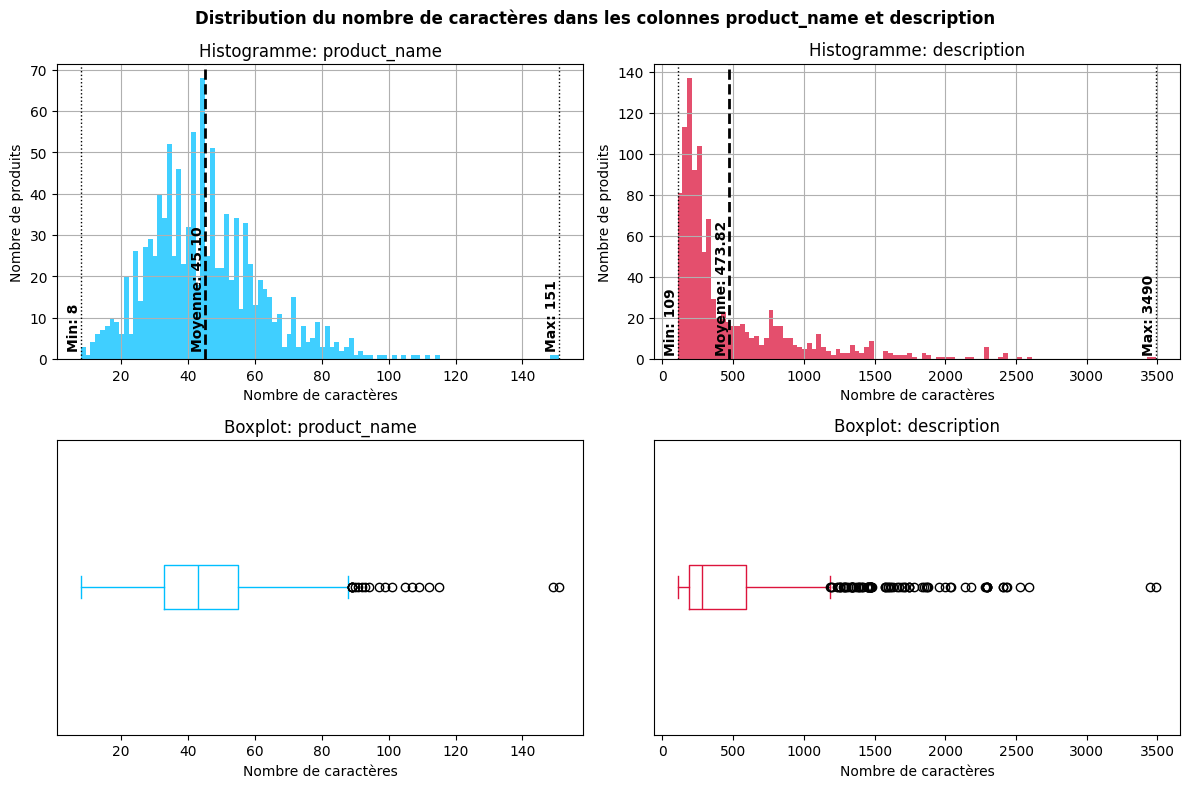

In [7]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution du nombre de caractères dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('product_name', 'description'),
    ('deepskyblue', 'crimson'),
    )):
    # On calcule le nombre de caractères pour chaque produit
    series = text_df[column].str.len()
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Nombre de caractères', ylabel='Nombre de produits', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Nombre de caractères', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()
    


**Les éléments clés à tirer de cette visualisation**:
- `Product_name` : Distrubution gaussienne avec une moyenne et une médiane très proche et peu de valeurs extrêmes.
- `Description` : Distribution asymétrique avec une médiane bien plus basse que la moyenne et beaucoup de valeurs extrêmes. Présence de bruit dans les données peut être très importante.


**Passons à présent à l'analyse des tokens:**

In [8]:
# Charge un modèle de langue anglaise basique pour tokenizer
nlp = spacy.blank('en')

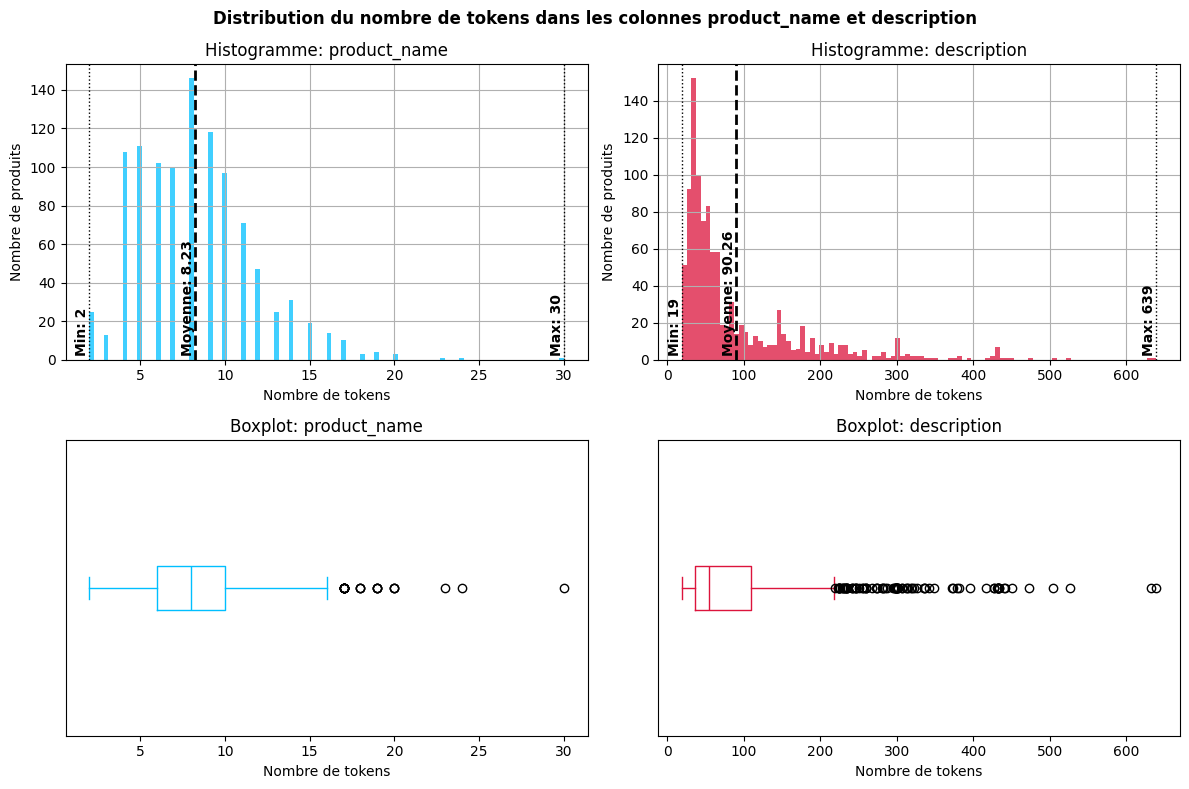

In [9]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution du nombre de tokens dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('product_name', 'description'),
    ('deepskyblue', 'crimson'),
    )):
    # On calcule le nombre de caractères pour chaque produit
    series = pd.Series([len(doc) for doc in nlp.pipe(text_df[column].values)])
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Nombre de tokens', ylabel='Nombre de produits', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Nombre de tokens', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()
    

Parmi les tokens extraits, regardons à présent leur longueur et leur fréquence d'apparition:


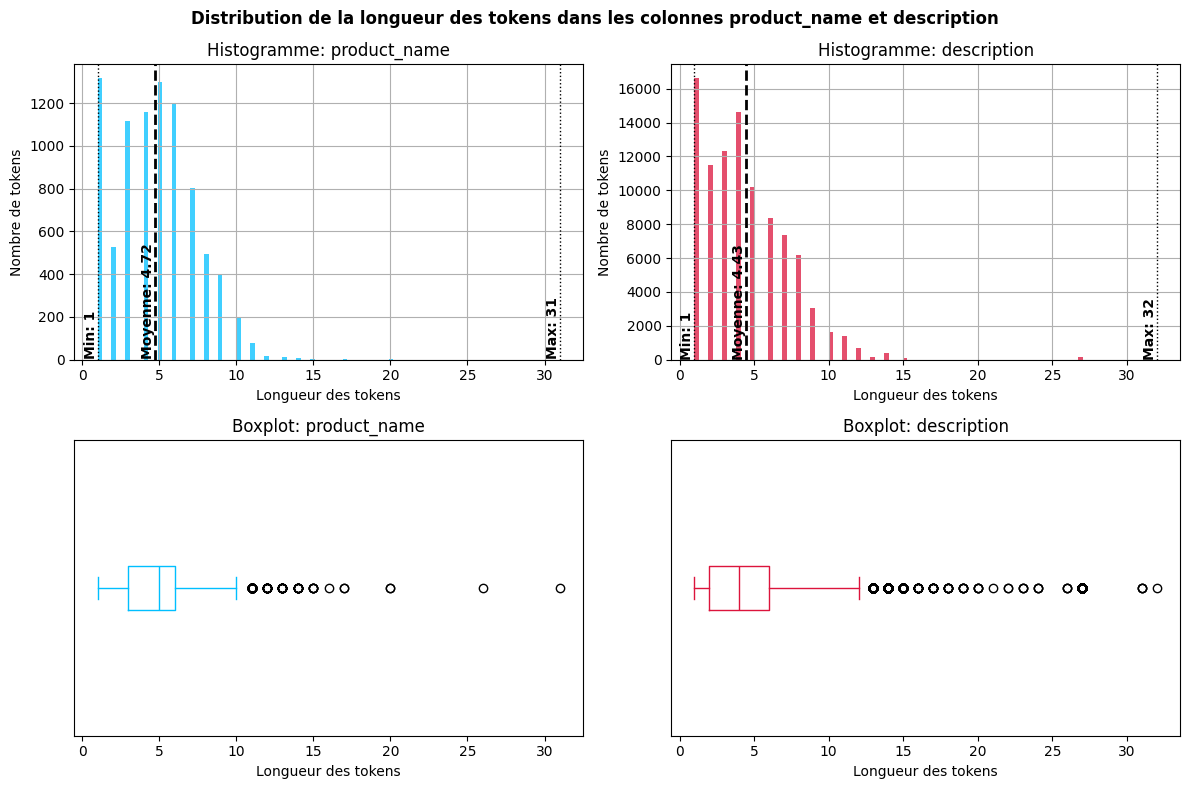

In [10]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution de la longueur des tokens dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('product_name', 'description'),
    ('deepskyblue', 'crimson'),
    )):
    # On calcule la longueur de chaque token pour chaque produit
    series = pd.Series([len(token) for doc in nlp.pipe(text_df[column].values) for token in doc])
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Longueur des tokens', ylabel='Nombre de tokens', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Longueur des tokens', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()

Je constate que sur les 2 séries, la fréquence la plus élévée est celle des tokens de longueur 1. Cela est dû à la présence de stopwords dans les données.<br>
D'un autre côté, des tokens dont la longueur est supérieure à 13 caractères sont très peu fréquents. Cela peut être dû à des erreurs de tokenisation ou à des mots très spécifiques.<br>
Poussons l'analyse en regardant si nous retrouvons certains patterns spécifiques dans les tokens.

## Recherche de patterns spécifiques dans les tokens (ex: email, url, etc...)

**Recherche de patterns spécifiques telles que les url, emails, citations ou hashtags**


On a constaté la présence d'une adresse email sur nos tokens longs. Vérifions la présence de ces différents types de pattern qui ne seraient pas informatifs dans notre analyse.

In [11]:
# Define a pattern to match urls in the description column
url = r"www\.\S+"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type URL")
print(text_df["product_name"].str.findall(url).apply(len).value_counts().index)
print(text_df["description"].str.findall(url).apply(len).value_counts().index)

Recherche de pattern de type URL
Index([0], dtype='int64', name='product_name')
Index([0], dtype='int64', name='description')


In [12]:
# Define an email pattern to match emails in the description column
email = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type Email")
print(text_df["product_name"].str.findall(email).apply(len).value_counts().index)
print(text_df["description"].str.findall(email).apply(len).value_counts().index)

Recherche de pattern de type Email
Index([0], dtype='int64', name='product_name')
Index([0, 1], dtype='int64', name='description')


In [13]:
# Define a pattern to capture the phone numbers in the description column
phone = r"\b\d{10}\b"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type no de téléphone")
print(text_df["product_name"].str.findall(phone).apply(len).value_counts().index)
print(text_df["description"].str.findall(phone).apply(len).value_counts().index)

Recherche de pattern de type no de téléphone
Index([0], dtype='int64', name='product_name')
Index([0], dtype='int64', name='description')


In [14]:
# Define a pattern to capture hashtags
hashtag = r"#\S+"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type hashtag")
print(text_df["product_name"].str.findall(hashtag).apply(len).value_counts().index)
print(text_df["description"].str.findall(hashtag).apply(len).value_counts().index)

Recherche de pattern de type hashtag
Index([0], dtype='int64', name='product_name')
Index([0, 32], dtype='int64', name='description')


In [15]:
# Define a pattern to capture mentions
mentions = r"@\S+"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type mentions")
print(text_df["product_name"].str.findall(mentions).apply(len).value_counts().index)
print(text_df["description"].str.findall(mentions).apply(len).value_counts().index)

Recherche de pattern de type mentions
Index([0, 1], dtype='int64', name='product_name')
Index([0, 2, 4, 1], dtype='int64', name='description')


In [16]:
# Supprime les patterns du type email et mention pour éviter de les traiter et aussi en rapport avec les normes RGPD
text_df["product_name"] = text_df["product_name"].str.replace(email, "")
text_df["description"] = text_df["description"].str.replace(email, "")


## Inspection des tokens de courte longueur

Passons à une phase d'inspection des erreurs de tokenisation et notamment ce que l'on a pu observé sur les distributions auparavant.<br>
Pour cela, je vais regarder les tokens les plus fréquents et les moins fréquents pour voir si certains tokens sont mal tokenisés ou si des erreurs de saisie sont présentes.

In [17]:
def print_custom(data, items_per_line=5):
    """
    Affiche les éléments de la liste avec un nombre fixe d'éléments par ligne.
    
    :param data: La liste de données à afficher.
    :param items_per_line: Nombre d'éléments par ligne.
    """
    for i in range(0, len(data), items_per_line):
        print(data[i:i + items_per_line])

**Inspection des TOKENS supérieurs ou égals à 13 caractères:**

In [18]:
# Affiche tous les tokens de longueur supérieure ou égal à 13 caractères
print_custom(list(
    set(
    [token.text for doc in nlp.pipe(text_df['product_name'].values) for token in doc if len(token.text) >= 13]
    ).union(set(
        [token.text for doc in nlp.pipe(text_df['description'].values) for token in doc if len(token.text) >= 13])
        )
)
)

['FURNISHINGLAND', 'FLVI51GREENC2X6', '10),Specifications', 'manufacturers', 'Goldencollections']
['11000026),Specifications', 'comprehensive', 'Supercritical', 'FLMH922BLACKC3X5', 'entrepreneurs']
['Compatibility', 'manufacturing', 'petrochemical', 'L*B*H-20x10x35', 'complementing']
['Scientifically', 'HE_BED_King_04', '\r\n\t\t\t\t\r\n\t\t\t\r\n\t', 'FLVI50REDC2X6', '10,Specifications']
['13cm,3kFactory', 'Antimicrobial', 'DLST2020_WHITE_TBLUE_NAVY_PURPLE', 'diversification', 'Customisation']
['furnishingland', 'CAU1116.BA0858', 'functionality', 'Multifunctional', 'concentration']
['MULTIFUNCTION', "MS004PKTBL-4'X6", 'painstakingly', 'Multicoloured', 'BLS00S380001B']
['groups!,Specifications', 'Interiordesign', 'sophistication', '...................', '",Specifications']
['Multifunctions', 'breathlessness', 'think!,Specifications', '9.825000000000001', 'Durable,,Bela']
['Moisturization', 'Manufacturing', '8904214703639', 'malfunctioning', 'theseuberstylish']
['Customization', 'Specif

On relève principalement des erreurs de tokenisation avec des caractères de ponctuation ou des mots composés mal séparés.<br>
Traitons les avec deux patterns généralistes pour corriger ce type d'erreur:

In [19]:
# Corrige les exceptions suivantes lors de la tokenisation
for column in ('product_name', 'description'):
    text_df[column] = text_df[column].str.replace(r'(?<=\w)[,-_.!()"]+(?=\w)', ' ', regex=True) # Gère les caractères de type ,-_.!() qui sont au milieu d'une chaîne de caractères
    text_df[column] = text_df[column].str.replace(r'[,]+(?=\w)', ' ', regex=True) # Gère les virgules qui sont au début d'une chaîne de caractères


**Inspection des TOKENS de 1 caractère**:

In [20]:
# Affiche tous les tokens de longueur égal à 1 caractère
print_custom(list(
    set(
    [token.text for doc in nlp.pipe(text_df['product_name'].values) for token in doc if len(token.text) == 1]
    ).union(set(
        [token.text for doc in nlp.pipe(text_df['description'].values) for token in doc if len(token.text) == 1])
        )
)
)

['�', 'Z', 'I', 'R', 'm']
['9', ')', 'C', '#', 's']
['w', 'e', '"', '5', 'a']
[';', ',', '8', '“', 'E']
['Q', 'd', '%', 'Y', 'c']
['-', ':', '.', 'U', '2']
[' ', 'B', '[', 'n', 'A']
['/', 'V', ']', 'S', 'v']
['(', 'F', '?', 'k', 'o']
['J', "'", 'H', 't', 'N']
['K', 'L', 'T', 'g', '6']
['y', '–', 'D', '0', '+']
['1', '4', '|', 'P', 'X']
['\r', 'G', '3', '…', 'z']
['x', 'M', '@', '\u2028', '”']
['&', 'i', '\xa0', '•', 'h']
['*', 'b', '7', 'u', 'O']
['!', '°', 'l', 'W']


On note la présence de caractère non ASCII, beaucoup de ponctuation et de stopwords (notamment lié aux unités de mesure).<br>
Traitons uniquement le remplacement des caractères non ASCII selon leur nature:

In [21]:
# Corrige les exceptions suivantes lors de la tokenisation
for column in ('product_name', 'description'):
    text_df[column] = text_df[column].str.replace(r'\u2028', r'\n', regex=True) # Gère les caractères de type \u2028 comme un saut de ligne
    text_df[column] = text_df[column].str.replace(r'\xa0', ' ', regex=True) # Gère les caractères de type \xa0 comme un espace
    text_df[column] = text_df[column].str.replace(r'�', '', regex=True) # Gère les caractères de type � comme une chaîne vide

**Inspection des TOKENS de 2 caractères**:

In [22]:
# Affiche tous les tokens de longueur égal à 2 caractères
print_custom(list(
    set(
    [token.text for doc in nlp.pipe(text_df['product_name'].values) for token in doc if len(token.text) == 2]
    ).union(set(
        [token.text for doc in nlp.pipe(text_df['description'].values) for token in doc if len(token.text) == 2])
        )
), items_per_line=15
)

['36', 'Do', '86', 'ad', 'Oz', 'As', 'YK', 'll', 'HG', 're', 'Re', 'ST', 'ml', 'up', '25']
['SJ', 'MH', 'Ac', 'In', 'ag', '45', 'Y.', 'SF', 'nt', 'tx', 'Sp', 'By', 've', '28', 'A5']
['95', 'ts', '91', 'MB', '57', 'wr', 'at', 'Nx', '35', 'OS', '3d', 'my', 'Up', 'Go', "''"]
['.5', 'Hd', 'se', 'pc', 'ed', '-A', 'E.', '4D', '23', 'rk', 'an', '90', 'LX', 'no', 'CP']
['46', 'OF', 'go', '53', '69', 'c-', 'Be', '-1', '85', "'S", 'el', 'NA', '14', '12', 'ry']
['Mb', '84', '\r\n', '27', 'A6', 'Me', 'Al', '19', 'om', '39', '06', 'ac', '-2', 'To', '01']
['18', 'it', '64', 'CL', 'ML', 'in', 'TC', 'Hz', 'B/', 'AT', 'OR', '51', 'Gm', '30', 'WE']
['59', 'lm', 'kg', '11', 'co', 'tu', "'s", '-4', 'S.', 'c.', 'he', '13', 'IT', 'oQ', 'AC']
['10', 'gm', '..', 'ha', 'is', 'Of', '//', 'V9', 'K.', 'Rs', 'MN', 'IC', 'e.', '58', 'ro']
['cm', 'wo', 'Cm', 'do', 'CE', 'If', 'ee', 'cs', '34', '65', '’s', 'Pc', '60', 'sq', '17']
['33', 'SD', 'It', 'h.', 'Fs', 'ME', 'hp', '0/', 'KE', 'HD', 'HP', 'On', '37', 'PC', '70

A nouveau, on retrouve tout un tas de stopwords ainsi que des unités de mesure.<br>
Créons une liste de stopwords liés aux unités de mesure:

In [23]:
# Création d'une liste de stopwords liés aux unités de mesure anglaises ou françaises
stopwords = [
    'cm', 'mm', 'm', 'km', 'ft', 'in', 'yd',
    'mi', 'g', 'gm', 'kg', 't', 'oz',
    'lb', 'mg', 'l', 'ml', 'cl',
    'gal', 'pt', 'qt', 'fl', 'oz',
    'ac', 'l', 'ml', 'cl', 'c', 'f'
]

## Libération de la mémoire

In [24]:
# Suppression des variables intermédiaires à ne pas conserver en mémoire
del(url, email, phone, hashtag, mentions, series, min, max, mean)
collect()

45390

# **EVALUATION DE LA SEGMENTATION NON SUPERVISEE**

In [25]:
# Définition du fonction pour calculer l'ARI après segmentation avec KMeans et réduction de dimension avec Tsne
def compute_ari(X, y=text_df['class'], tsne=True):
    # Détermination des clusters à partir des données avant Tsne
    cls = KMeans(n_clusters=y.nunique(), n_init=100, random_state=42)
    cls.fit(X)

    # Calcul de l'ARI
    ARI = np.round(adjusted_rand_score(y, cls.labels_), 4)

    # Réduction de dimension avec Tsne si tsne=True
    if tsne:
        tsne = TSNE(
            n_components=2,
            perplexity=30,
            max_iter=2000,
            init="random",
            learning_rate=200,
            random_state=42,
        )
        X_tsne = tsne.fit_transform(X)
        # Retourne l'ARI, les données réduites et les clusters
        return ARI, X_tsne, cls.labels_
    else:
        # Retourne l'ARI et les clusters
        return ARI, cls.labels_

In [26]:
# Définit une fonction pour comparer les embeddings TSNE avec les catégories réelles et les clusters
def compare_cluster_and_cat(X_tsne, clusters, y=text_df['class']):
    fig = plt.figure(figsize=(13, 5), tight_layout=True)

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.cat.codes, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=y.unique(),
        loc="best",
        title="Categorie",
    )
    plt.title("Représentation des commentaires par catégories réelles")

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(clusters),
        loc="best",
        title="Clusters",
    )
    plt.title("Représentation des commentaires par clusters")

    plt.show()

In [27]:
# Définit une fonction pour prétraiter le texte
def preprocess_text(doc):  
    tokens = [
        token.lemma_
        for token in nlp(doc)
        if not token.is_stop and not token.like_num and token.is_alpha and token.lemma_ not in stopwords
        ]
    return " ".join(tokens)

## Création des corpus pour chaque champ textuel

In [28]:
# Load large english model
nlp = spacy.load('en_core_web_lg', disable=['ner'])

# Affiche les composantes du pipeline
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


In [29]:
# Créé un dictionnaire pour stocker les données prétraitéee
corpus = dict()
# Ajoute les données prétraitées pour chaque colonne
for column in ('product_name', 'description'):
    corpus[column] = text_df[column].transform(lambda x: preprocess_text(x.lower()))
# Ajoute les données prétraitées pour la colonne 'full' qui est la concaténation des colonnes 'product_name' et 'description'
corpus['full'] = corpus['product_name'] + ' ' + corpus['description']

## Count Vectorizer

En fonction du type d'embeddings que nous allons utiliser, nous allons choisir une méthode de clustering adaptée.<br>
Passons en revue les différents types d'embeddings :
* **CountVectorizer** : Génère un BOW (fréquence de chaque mot présent dans le corpus au sein de chaque document). En fonction du nombre de dimensions obtenues, il sera peut-être nécessaire de réduire la dimensionnalité avant d'utiliser une méthode de clustering.
* **TfidfVectorizer** : Génère un BOW pondéré par l'inverse de la fréquence du mot dans le corpus. En fonction du nombre de dimensions obtenues, il sera peut-être nécessaire de réduire la dimensionnalité avant d'utiliser une méthode de clustering.

La démarche est de générer différents BOW et de tester l'ARI.<br>
Une première étape importante sur les BOW est de réduire la dimensionnalité pour éviter le fléau de la dimensionnalité.<br>
Afin de gagner du temps sur les calculs, nous allons créer nos corpus de texte dans un dictionnaire `corpus`:

Nous allons créer deux corpus de documents :
* `corpus`: contient tous les documents textes sans preprocessing quelconque.
* `corpus_preprocessed`: contient tous les documents textes après preprocessing.

On peut regarder à présent si nous avons des pattern à haute fréquence dans les documents textes et de vérifier s'il s'agit de bruit:

In [49]:
def embeddings_df(vectorizer, corpus):
    """
    Transforme une matrice sparse en DataFrame.
    
    :param cv: Le vecteur CountVectorizer.
    :param corpus: Le corpus de texte.
    :return: Un DataFrame.
    """
    # Fit and transform the corpus
    embeddings = vectorizer.fit_transform(corpus)

    # Création d'un DataFrame avec les données de product_cv et les colonnes product_cv_columns
    df = pd.DataFrame(
        embeddings.toarray(),
        columns=vectorizer.get_feature_names_out()
        )
    
    # Retourne le DataFrame
    return df

In [74]:
# Crée un count vectorizer avec la suppression des accents et le reste des paramètres par défaut
cv = CountVectorizer(strip_accents="unicode")

# Crée un dictionnaire qui va contenir les embeddings pour chaque colonne
df = dict()

# Retourne le DataFrame des embeddings pour les colonnes product_name
for column in ('product_name', 'description', 'full'):
    df[column] = embeddings_df(cv, corpus[column])

# Affiche le nombre de features pour chaque colonne
for column in ('product_name', 'description', 'full'):
    print(f"Nombre de features pour {column}: {df[column].shape[1]}")

Nombre de features pour product_name: 1671
Nombre de features pour description: 4140
Nombre de features pour full: 4144


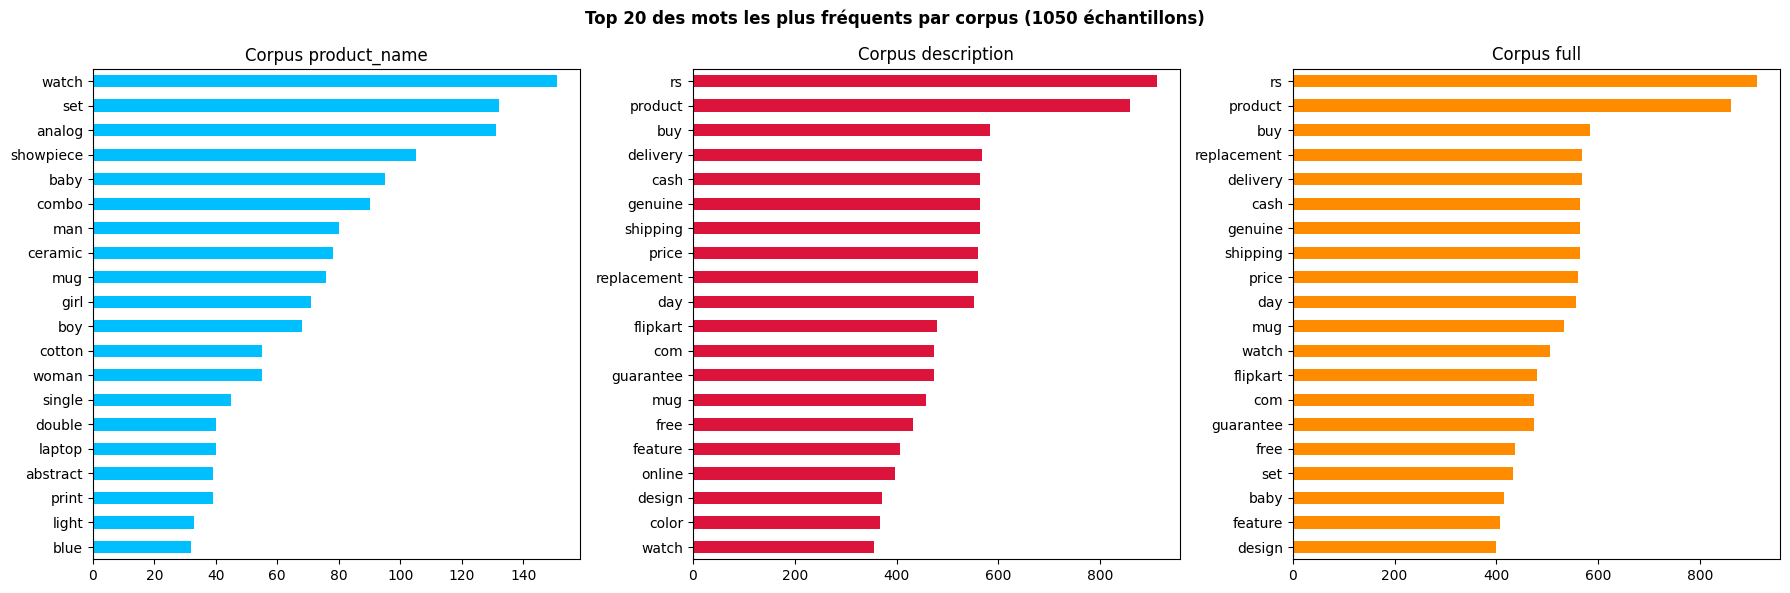

In [75]:
# Crée une figure comparant les barplot des 20 mots les plus fréquents pour chaque colonne
fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
fig.suptitle(f'Top 20 des mots les plus fréquents par corpus ({len(text_df)} échantillons)', fontweight='bold')
colors = ['deepskyblue', 'crimson', 'darkorange']
# Itère sur chaque df
for i, column in enumerate(('product_name', 'description', 'full')):
    (df[column].sum(axis=0).nlargest(20)
    .sort_values(ascending=True)
    .plot(kind='barh', color=colors[i], ax=ax[i], title=f'Corpus {column}')
    )

On peut constater la présence de stopwords et de mots très fréquents qui ne sont pas informatifs pour notre analyse dans la colonne `description`.<br>
Testons déjà l'ARI sans modifier nos stopwords pour voir l'impact de ces mots sur la qualité de notre clustering.

In [73]:
for column in ('product_name', 'description', 'full'):
    ari, _ = compute_ari(df[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.2646
ARI pour description : 0.0444
ARI pour full : 0.1742


L'impact des stopwords fréquents est très important sur la qualité de notre clustering.<br>
Par ex., `rs` (diminutif pour rupees) est présent dans environ 80 % des documents et ne sont pas informatifs pour notre analyse.<br>
Ajoutons les à notre liste de stopwords:

In [78]:
# Ajout de nouveaux mots génériques à la liste des stopwords
stopwords.extend([
    'rs', 'product', 'buy', 'delivery', 'cash',
    'guenine', 'shipping', 'price', 'replacement',
    'day', 'flipkart', 'com', 'guarantee', 'feature',
    'free', 'price',
    ])
# Convertit la liste en set pour éliminer les duplicatas et la reconvertit en liste
stopwords = list(set(stopwords))

Afin d'évaluer d'optimiser notre ARI, je vais définir une grille de paramètres pour finer tuning de notre CountVectorizer.

In [103]:
params_grid = {
    'ngram_range': [(1, 1), (1, 2), (2,2)],
    'max_df': [0.25, 0.5, 0.75, 1.0],
    'min_df': [1, 2, 3, 5],
}
# Crée une liste avec toutes les combinaisons possibles
combinations = list(product(*params_grid.values()))
# Affiche le nombre de combinaisons possibles
print("Nombre de combinaisons possibles:", len(combinations))
print("Minimum à tester: ", len(combinations) // 4)

Nombre de combinaisons possibles: 48
Minimum à tester:  12


In [106]:
# Fixe le seed pour la reproductibilité et le nombre d'itérations
np.random.seed(42)
n_iter = 12

# Crée un dictionnaire pour stocker les scores et les paramètres par colonne
scores_dict = defaultdict(list)

for _ in tqdm(range(n_iter)):
    # Sélectionne aléatoirement une combinaison de paramètres
    i = np.random.choice(len(combinations), size=1, replace=False)[0]
    ngram_range, max_df, min_df = combinations[i]
    # Itère sur chaque colonne
    for column in ('product_name', 'description', 'full'):
        # Crée un CountVectorizer avec les paramètres sélectionnés
        cv = CountVectorizer(strip_accents="unicode", stop_words=stopwords, ngram_range=ngram_range, max_df=max_df, min_df=min_df)
        # Crée un DataFrame avec les embeddings
        df = embeddings_df(cv, corpus[column])
        ari, _= compute_ari(df, tsne=False)
        # Ajoute un tuple avec les paramètres, le nombre de features et l'ARI
        scores_dict[column].append((ngram_range, max_df, min_df, df.shape[1], ari))

100%|██████████| 12/12 [04:57<00:00, 24.78s/it]


In [122]:
# Crée un dataframe avec les scores avec les colonnes : nom_colonne, max_df, min_df, n_features, ARI
scores_df = pd.DataFrame(
    [
        (column, ngram_range, max_df, min_df, n_features, ari)
        for column, scores in scores_dict.items()
        for ngram_range, max_df, min_df, n_features, ari in scores
    ],
    columns=['column', 'ngram_range', 'max_df', 'min_df', 'n_features', 'ARI']
).assign(**{'ngram_code': lambda x: x['ngram_range'].astype('category').cat.codes})

# Affiche les 5 premières lignes du dataframe
print(scores_df.nlargest(5, 'ARI'))

          column ngram_range  max_df  min_df  n_features     ARI  ngram_code
9   product_name      (1, 1)     0.5       2         612  0.2171           0
2   product_name      (1, 1)     1.0       1        1666  0.1923           0
4   product_name      (1, 1)     1.0       1        1666  0.1923           0
26          full      (1, 1)     1.0       1        4130  0.1602           0
28          full      (1, 1)     1.0       1        4130  0.1602           0


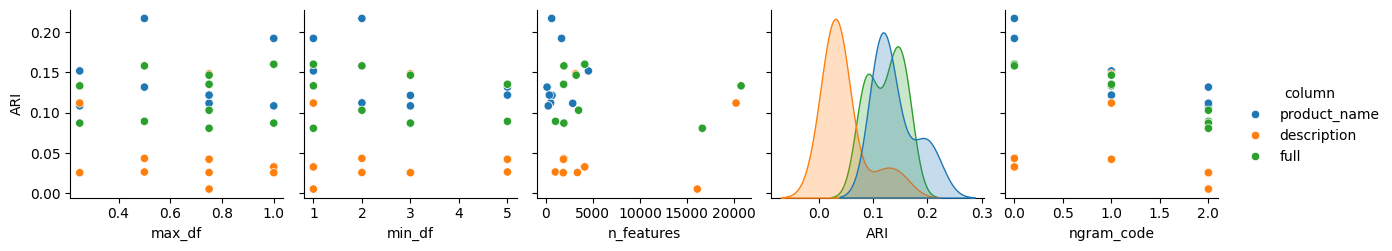

In [118]:
sns.pairplot(scores_df, hue='column', y_vars=['ARI'], diag_kind='kde', kind='scatter')
plt.show()

In [125]:
params_grid = {
    'ngram_range': [(1, 1)],
    'max_df': [0.4, 0.45, 0.5, 0.55, 0.6],
    'min_df': [1, 2],
    'max_features': [500, 600, 700],
}
# Crée une liste avec toutes les combinaisons possibles
combinations = list(product(*params_grid.values()))
# Affiche le nombre de combinaisons possibles
print("Nombre de combinaisons possibles:", len(combinations))

Nombre de combinaisons possibles: 30


In [126]:
# Fixe le seed pour la reproductibilité et le nombre d'itérations
np.random.seed(42)
n_iter = 20

# Crée un dictionnaire pour stocker les scores et les paramètres par colonne
scores_dict = defaultdict(list)

for _ in tqdm(range(n_iter)):
    # Sélectionne aléatoirement une combinaison de paramètres
    i = np.random.choice(len(combinations), size=1, replace=False)[0]
    ngram_range, max_df, min_df, max_features = combinations[i]
    # Itère sur chaque colonne
    for column in ('product_name',):
        # Crée un CountVectorizer avec les paramètres sélectionnés
        cv = CountVectorizer(strip_accents="unicode", stop_words=stopwords, ngram_range=ngram_range, max_df=max_df, min_df=min_df, max_features=max_features)
        # Crée un DataFrame avec les embeddings
        df = embeddings_df(cv, corpus[column])
        ari, _= compute_ari(df, tsne=False)
        # Ajoute un tuple avec les paramètres, le nombre de features et l'ARI
        scores_dict[column].append((ngram_range, max_df, min_df, max_features, df.shape[1], ari))

100%|██████████| 20/20 [00:54<00:00,  2.72s/it]


In [129]:
# Crée un dataframe avec les scores avec les colonnes : nom_colonne, max_df, min_df, n_features, ARI
scores_df = pd.DataFrame(
    [
        (column, ngram_range, max_df, min_df, max_features, n_features, ari)
        for column, scores in scores_dict.items()
        for ngram_range, max_df, min_df, max_features, n_features, ari in scores
    ],
    columns=['column', 'ngram_range', 'max_df', 'min_df', 'max_features', 'n_features', 'ARI']
)

# Affiche les 5 premières lignes du dataframe
print(scores_df.nlargest(5, 'ARI'))

         column ngram_range  max_df  min_df  max_features  n_features     ARI
2  product_name      (1, 1)    0.40       2           600         600  0.2722
7  product_name      (1, 1)    0.45       2           600         600  0.2722
9  product_name      (1, 1)    0.50       2           600         600  0.2722
0  product_name      (1, 1)    0.60       2           500         500  0.2695
3  product_name      (1, 1)    0.40       2           500         500  0.2695


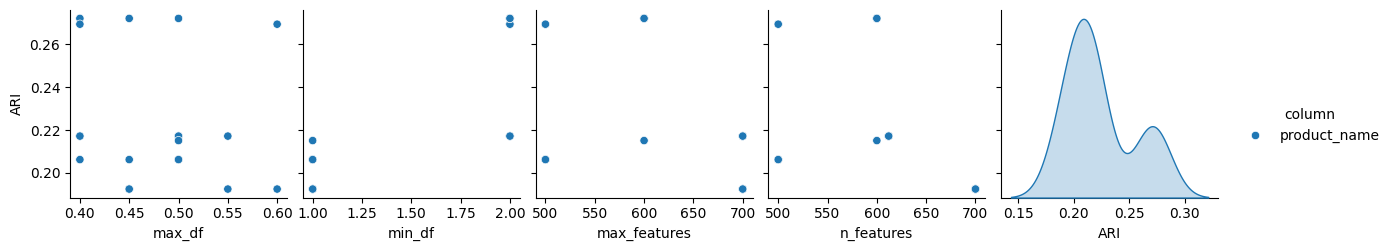

In [130]:
sns.pairplot(scores_df, hue='column', y_vars=['ARI'], diag_kind='kde', kind='scatter')
plt.show()

ARI score: 0.2722 - Colone: product_name - Params: {'ngram_range': (1, 1), 'max_df': 0.4, 'min_df': 2, 'max_features': 600}


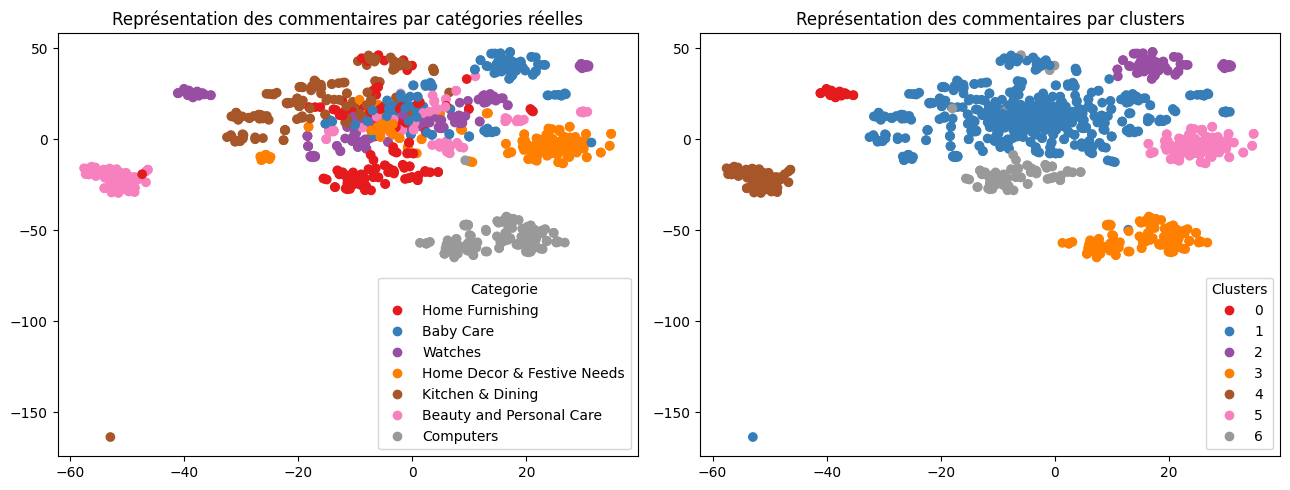

In [131]:
# Crée un CountVectorizer avec les paramètres sélectionnés
params = {"ngram_range" :(1, 1), "max_df": 0.4, "min_df": 2, "max_features": 600}
cv = CountVectorizer(strip_accents="unicode", stop_words=stopwords, **params)
# Crée un DataFrame avec les embeddings
df = embeddings_df(cv, corpus['product_name'])
ari, X_tsne, labels = compute_ari(df, tsne=True)
print(f"ARI score: {ari} - Colone: product_name - Params: {params}")
compare_cluster_and_cat(X_tsne, labels)

## Tfidf Vectorizer

In [132]:
# Crée un count vectorizer avec la suppression des accents et le reste des paramètres par défaut
tfidf = TfidfVectorizer(strip_accents="unicode")

# Crée un dictionnaire qui va contenir les embeddings pour chaque colonne
df = dict()

# Retourne le DataFrame des embeddings pour les colonnes product_name
for column in ('product_name', 'description', 'full'):
    df[column] = embeddings_df(tfidf, corpus[column])

# Affiche le nombre de features pour chaque colonne
for column in ('product_name', 'description', 'full'):
    print(f"Nombre de features pour {column}: {df[column].shape[1]}")

Nombre de features pour product_name: 1671
Nombre de features pour description: 4140
Nombre de features pour full: 4144


In [133]:
for column in ('product_name', 'description', 'full'):
    ari, _ = compute_ari(df[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.2347
ARI pour description : 0.2381
ARI pour full : 0.2435


In [ ]:
# Crée une figure comparant les barplot des 20 mots les plus fréquents pour chaque colonne
fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
fig.suptitle(f'Top 20 des mots les plus fréquents par corpus ({len(text_df)} échantillons)', fontweight='bold')
colors = ['deepskyblue', 'crimson', 'darkorange']
# Itère sur chaque df
for i, column in enumerate(('product_name', 'description', 'full')):
    (df[column].sum(axis=0).nlargest(20)
    .sort_values(ascending=True)
    .plot(kind='barh', color=colors[i], ax=ax[i], title=f'Corpus {column}')
    )

In [136]:
params_grid = {
    'ngram_range': [(1, 1), (1, 2), (2, 2)],
    'max_df': [0.25, 0.5, 0.75],
    'min_df': [2, 4, 6],
    'norm': ['l1', 'l2'],
    'sublinear_tf': [True, False],
}
# Crée une liste avec toutes les combinaisons possibles
combinations = list(product(*params_grid.values()))
# Affiche le nombre de combinaisons possibles
print("Nombre de combinaisons possibles:", len(combinations))
print("Minimum à tester: ", len(combinations) // 4)

Nombre de combinaisons possibles: 108
Minimum à tester:  27


In [137]:
# Fixe le seed pour la reproductibilité et le nombre d'itérations
np.random.seed(42)
n_iter = 27

# Crée un dictionnaire pour stocker les scores et les paramètres par colonne
scores_dict = defaultdict(list)

for _ in tqdm(range(n_iter)):
    # Sélectionne aléatoirement une combinaison de paramètres
    i = np.random.choice(len(combinations), size=1, replace=False)[0]
    ngram_range, max_df, min_df, norm, sublinear_tf = combinations[i]
    # Itère sur chaque colonne
    for column in ('product_name', 'description', 'full'):
        # Crée un CountVectorizer avec les paramètres sélectionnés
        tfidf = TfidfVectorizer(
            strip_accents="unicode", stop_words=stopwords,
            ngram_range=ngram_range, max_df=max_df, min_df=min_df,
            norm=norm, sublinear_tf=sublinear_tf
            )
        # Crée un DataFrame avec les embeddings
        df = embeddings_df(tfidf, corpus[column])
        ari, _= compute_ari(df, tsne=False)
        # Ajoute un tuple avec les paramètres, le nombre de features et l'ARI
        scores_dict[column].append((ngram_range, max_df, min_df, df.shape[1], norm, sublinear_tf, ari))

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [06:13<00:00, 13.83s/it]


In [140]:
# Crée un dataframe avec les scores avec les colonnes : nom_colonne, max_df, min_df, n_features, ARI
scores_df = pd.DataFrame(
    [
        (column, ngram_range, max_df, min_df, n_features, norm, sublinear_tf, ari)
        for column, scores in scores_dict.items()
        for ngram_range, max_df, min_df, n_features, norm, sublinear_tf, ari in scores
    ],
    columns=['column', 'ngram_range', 'max_df', 'min_df', 'n_features', 'norm', 'sublinear_tf', 'ARI']
).assign(**{'ngram_code': lambda x: x['ngram_range'].astype('category').cat.codes})

# Affiche les 5 premières lignes du dataframe
with pd.option_context('display.max_columns', 10):
    display(scores_df.nlargest(5, 'ARI'))

,column,ngram_range,max_df,min_df,n_features,norm,sublinear_tf,ARI,ngram_code
22,product_name,"(1, 1)",0.75,2,612,l2,True,0.3101,0
49,description,"(1, 1)",0.75,2,1909,l2,True,0.3055,0
74,full,"(1, 1)",0.25,6,738,l2,True,0.2881,0
1,product_name,"(1, 1)",0.50,2,612,l2,False,0.2808,0
6,product_name,"(1, 1)",0.25,2,612,l2,False,0.2808,0


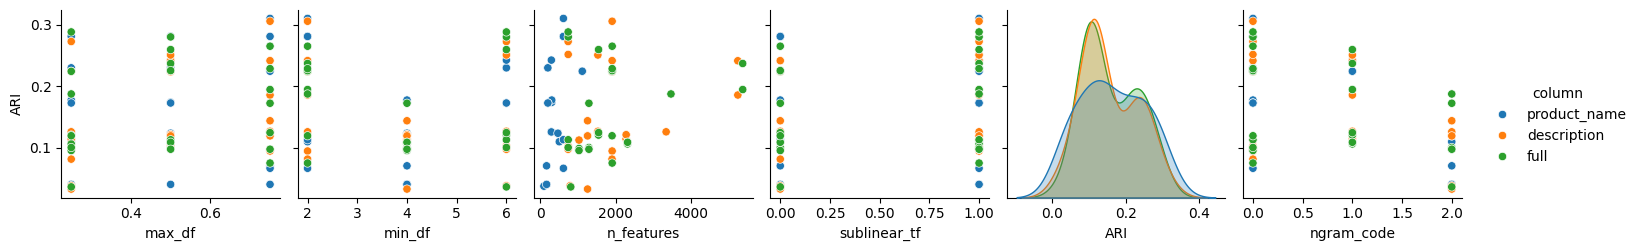

In [141]:
sns.pairplot(scores_df, hue='column', y_vars=['ARI'], diag_kind='kde', kind='scatter')
plt.show()

La configuration avec le corpus 'text' et les paramètres 4 obtient le meilleur score ARI.<br>
Regardons à présent la visualisation obtenue:

In [152]:
params_grid = {
    'ngram_range': [(1, 1), ],
    'max_df': [0.7, 0.75, 0.8],
    'min_df': [2, 3],
    'max_features': [350, 450, 650],
    'norm': ['l2', ],
    'sublinear_tf': [True, False],
}
# Crée une liste avec toutes les combinaisons possibles
combinations = list(product(*params_grid.values()))
# Affiche le nombre de combinaisons possibles
print("Nombre de combinaisons possibles:", len(combinations))

Nombre de combinaisons possibles: 36


In [153]:
# Fixe le seed pour la reproductibilité et le nombre d'itérations
np.random.seed(42)
n_iter = 36

# Crée un dictionnaire pour stocker les scores et les paramètres par colonne
scores_dict = defaultdict(list)

for _ in tqdm(range(n_iter)):
    # Sélectionne aléatoirement une combinaison de paramètres
    i = np.random.choice(len(combinations), size=1, replace=False)[0]
    ngram_range, max_df, min_df, max_features, norm, sublinear_tf = combinations[i]
    # Itère sur chaque colonne
    for column in ('product_name', ):
        # Crée un CountVectorizer avec les paramètres sélectionnés
        tfidf = TfidfVectorizer(
            strip_accents="unicode", stop_words=stopwords,
            ngram_range=ngram_range, max_df=max_df, min_df=min_df,
            max_features=max_features, norm=norm, sublinear_tf=sublinear_tf
            )
        # Crée un DataFrame avec les embeddings
        df = embeddings_df(tfidf, corpus[column])
        ari, _= compute_ari(df, tsne=False)
        # Ajoute un tuple avec les paramètres, le nombre de features et l'ARI
        scores_dict[column].append((ngram_range, max_df, min_df, max_features, df.shape[1], norm, sublinear_tf, ari))

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [01:33<00:00,  2.59s/it]


In [154]:
# Crée un dataframe avec les scores avec les colonnes : nom_colonne, max_df, min_df, n_features, ARI
scores_df = pd.DataFrame(
    [
        (column, ngram_range, max_df, min_df, max_features, n_features, norm, sublinear_tf, ari)
        for column, scores in scores_dict.items()
        for ngram_range, max_df, min_df, max_features, n_features, norm, sublinear_tf, ari in scores
    ],
    columns=['column', 'ngram_range', 'max_df', 'min_df', 'max_features', 'n_features', 'norm', 'sublinear_tf', 'ARI']
).assign(**{'ngram_code': lambda x: x['ngram_range'].astype('category').cat.codes})

# Affiche les 5 premières lignes du dataframe
with pd.option_context('display.max_columns', 10):
    display(scores_df.nlargest(5, 'ARI'))

,column,ngram_range,max_df,min_df,max_features,n_features,norm,sublinear_tf,ARI,ngram_code
22,product_name,"(1, 1)",0.8,2,650,612,l2,True,0.3101,0
8,product_name,"(1, 1)",0.8,3,350,350,l2,True,0.2999,0
9,product_name,"(1, 1)",0.8,3,350,350,l2,True,0.2999,0
14,product_name,"(1, 1)",0.7,3,350,350,l2,True,0.2999,0
32,product_name,"(1, 1)",0.7,3,350,350,l2,True,0.2999,0


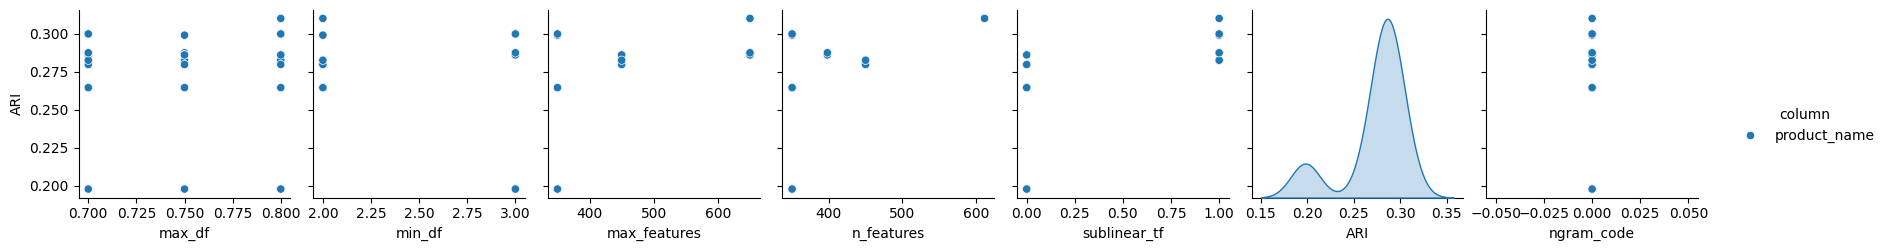

In [155]:
sns.pairplot(scores_df, hue='column', y_vars=['ARI'], diag_kind='kde', kind='scatter')
plt.show()

ARI score: 0.3101 - Colone: product_name - Params: {'ngram_range': (1, 1), 'max_df': 0.8, 'min_df': 2, 'max_features': 650, 'norm': 'l2', 'sublinear_tf': True}


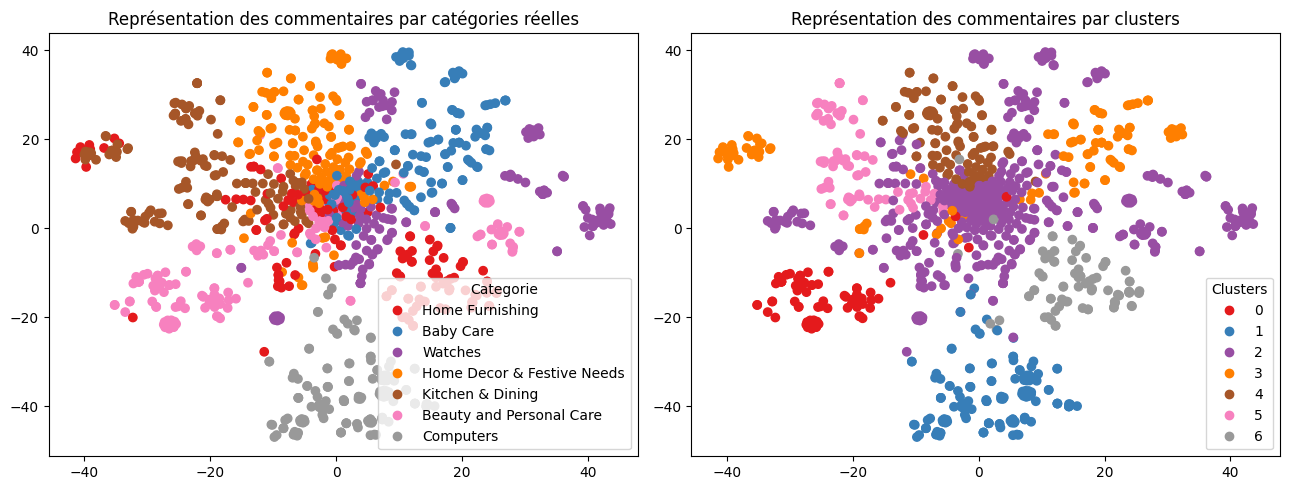

In [156]:
# Crée un TfIdfVectorizer avec les paramètres sélectionnés
params = {"ngram_range" :(1, 1), "max_df": 0.8, "min_df": 2, "max_features": 650, "norm": "l2", "sublinear_tf": True}
tfidf = TfidfVectorizer(strip_accents="unicode", stop_words=stopwords, **params)
# Crée un DataFrame avec les embeddings
df = embeddings_df(tfidf, corpus['product_name'])
ari, X_tsne, labels = compute_ari(df, tsne=True)
print(f"ARI score: {ari} - Colone: product_name - Params: {params}")
compare_cluster_and_cat(X_tsne, labels)

## WORD2VEC

Word2Vec est un réseau de neurones à 3 couches (entrée, hidden layer - compressed feature vector, sortie) pour projeter le mot dans un nouvel espace dont les dimensions sont caractérisées par le nombre de neurones dans la couche cachée.<br>
Plus le nombre de neurones de la couche cachée augmente et plus la dimensionnalité de l'espace de projection augmente. Chaque dimension est assimilable à une caractéristique sémantique du mot qui varie en fonction du contexte dans lequel il est utilisé.<br>
Le contexte est défini par la fenêtre de contexte qui est le nombre de mots avant et après le mot à prédire.


Pour définir le nombre de neurones de la couche cachée, il est possible de se baser sur la formule suivante :<br>
`hidden_layer_neurons = (2 * window_size + 1) * embedding_size`<br>
Dans notre cas, nous avons un window_size de 4 et un embedding_size de 100, donc nous allons choisir 900 neurones pour la couche cachée.

Nous allons entraîner notre modèle Word2Vec sur le corpus prétraité et regarder les mots les plus similaires à un mot donné :



Le modèle a été entraîné sur un corpus de texte très large et est capable de capturer les relations sémantiques entre les mots en utilisant la méthode SkipGram.<br>


La méthode d'entraînement sur notre corpus est intérressante à tester car elle permet de capturer les relations sémantiques entre les mots dans notre contexte particulier (description de produits).


Nous pouvons ensuite la comparer avec un modèle Word2Vec pré-entraîné sur un corpus de texte plus large et libre de droit (Wikipedia2vec)

### Utilisation du modèle `Word2vec/wikipedia2vec_frwiki_20180420_300d`

Je vais utiliser le modèle wikipedia2vec_frwiki_20180420_300d pour générer les embeddings des documents textes.<br>
Il a été entraîné avec les paramètres suivants : taille de fenêtre de 5, taille de vecteur de 300, 10 itérations et un sous-échantillonnage de 1e-5.<br>


Nous allons tester les performances de deux modèles Word2Vec pré-entraînés sur le corpus de wikipedia en anglais:
- 100d
- 300d

In [31]:
# Définit le repo_id et le nom du fichier du modèle 100d
repo_id = "Word2vec/wikipedia2vec_enwiki_20180420_100d"
filename = "enwiki_20180420_100d.txt"

# Récupère l'url pour télécharger le fichier (si besoin, en cas d'erreur de certificat SSL)
url = hf_hub_url(repo_id, filename, repo_type="model")

# Lit le fichier depuis le répertoire Word2vec
path = './word2vec/'
w2c_100 = KeyedVectors.load_word2vec_format(path+filename, binary=False)

In [34]:
# Loading the vectors from the glove text file
def load_word_vectors(file):
    with open(file, "r", encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return words, word_to_vec_map

In [33]:
# Compte le nombre de mots dans le vocab
vocab = list(w2c_100.key_to_index.keys())
print(f"Taille du vocabulaire du modèle {filename} : {len(vocab)} mots")

Taille du vocabulaire du modèle enwiki_20180420_100d.txt : 4530030 mots


In [38]:
word_to_vec_map = dict()
for word in vocab:
    word_to_vec_map[word] = w2c_100[word]

In [36]:
# récupère le vecteur associé au mot 'king'
king = w2c_100['king']
print(king)

[ 6.290e-02  2.230e-02  4.510e-01 -1.620e-02  3.985e-01 -6.590e-02
  4.334e-01  9.800e-02 -6.105e-01  1.680e-02 -6.200e-02  1.167e-01
  6.125e-01 -7.804e-01  1.250e-01 -1.001e-01 -1.234e-01 -2.259e-01
  2.815e-01  5.150e-02 -2.869e-01 -1.962e-01 -2.072e-01  1.118e-01
 -7.739e-01 -1.102e-01  3.452e-01 -5.316e-01  1.792e-01  5.650e-01
  1.162e-01 -9.440e-02 -2.202e-01  4.636e-01  3.135e-01 -1.856e-01
 -2.852e-01 -1.421e-01  2.247e-01 -6.170e-02 -1.201e-01 -3.090e-02
  3.743e-01  1.347e-01  2.950e-02  2.166e-01 -6.869e-01  6.377e-01
  2.905e-01  6.650e-02  2.993e-01  2.747e-01 -1.418e-01 -1.034e-01
 -3.268e-01 -1.560e-01 -2.698e-01  8.620e-02 -6.706e-01 -5.927e-01
  3.726e-01 -3.735e-01  2.200e-02  4.840e-02  2.411e-01 -1.792e-01
  1.400e-01  6.690e-02 -1.725e-01 -1.923e-01 -3.746e-01  5.210e-02
  1.635e-01  5.229e-01 -2.109e-01 -5.000e-04 -1.261e-01  3.470e-02
  3.800e-02 -1.784e-01  2.044e-01 -5.451e-01  3.420e-01 -1.630e-02
  1.474e-01  5.746e-01  2.365e-01  2.205e-01  4.692e-01  1.333

In [56]:
embeddings = dict()
for option in ('product_name', ):
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    embeddings[option] = corpus[option].apply(
        lambda x: np.mean(
            [word_to_vec_map[word] if word in word_to_vec_map else [0 for _ in range(100)] for word in x.split()],
            axis=0,
        )
    )

In [57]:
# Crée une matrice avec les embeddings de 1050 lignes et 100 colonnes
X = np.array([embedding for embedding in embeddings['product_name']])

In [59]:
X.shape

(1050, 100)

In [60]:
# Compute ari score
ari, X_tsne, labels = compute_ari(X, tsne=True)

ARI score: 0.2943


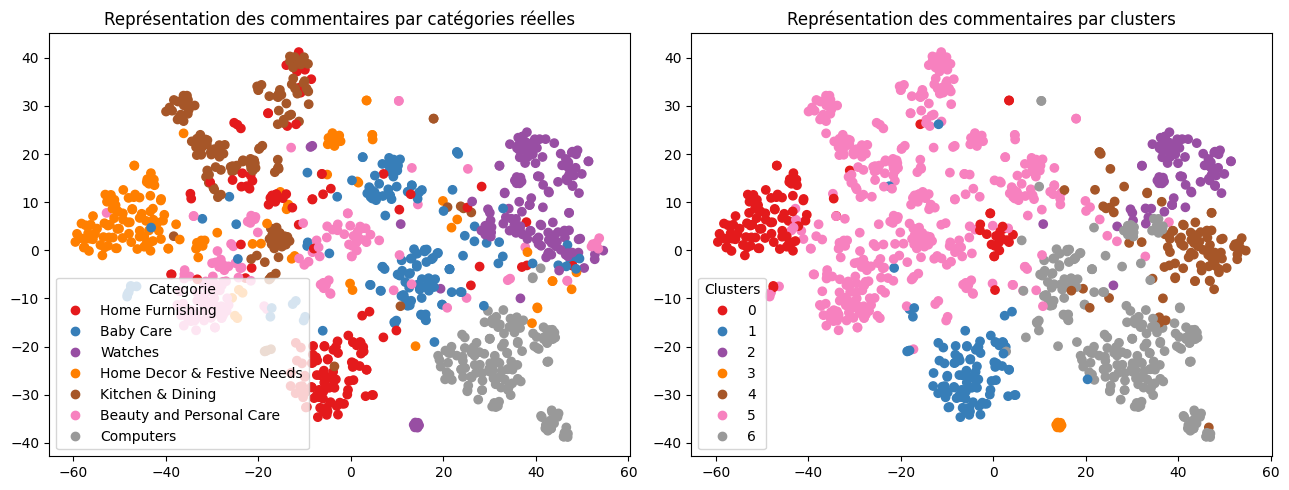

In [62]:
print(f"ARI score: {ari}")
compare_cluster_and_cat(X_tsne, labels)

### Entraînement du modèle Word2Vec (CBOW / Skipgram) sur le corpus prétraité

In [ ]:
from gensim.models import Word2Vec

In [ ]:
params = dict()

In [ ]:
params[0] = dict(
    min_count=1,
    window=5,
    vector_size=100,
    workers=4,
    sg=0,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42,
)

In [ ]:
params[1] = dict(
    min_count=1,
    window=7,
    vector_size=125,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42,
)

In [ ]:
params[2] = dict(
    min_count=1,
    window=10,
    vector_size=150,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42,
)

In [ ]:
params[3] = dict(
    min_count=3,
    window=10,
    vector_size=150,
    workers=4,
    sg=1,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    alpha=0.05,
    min_alpha=0.0001,
    seed=42,
)

In [ ]:
word_embeddings = dict()
model = dict()

for option in options:
    # Texte tokenisé
    text = [doc.split() for doc in flipkart_filtered[option]]

    for i in range(4):
        current_key = f"{option}" + f" {str(i)}"
        # Entraînement du modèle Word2Vec avec gensim
        model[option] = Word2Vec(sentences=text, **params[i])

        # Accès aux embeddings
        word_embeddings[current_key] = model[option].wv

        # Affichage du nombre de mots dans le vocabulaire
        print(
            f"{option} - Nombre de mots dans le vocabulaire: {len(word_embeddings[current_key].key_to_index)}"
        )

product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 2549
product_name - Nombre de mots dans le vocabulaire: 484
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 9587
description - Nombre de mots dans le vocabulaire: 3585
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 9587
text - Nombre de mots dans le vocabulaire: 4160


In [ ]:
mean_embeddings = dict()
for key in word_embeddings.keys():
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    mean_embeddings[key] = (
        flipkart_filtered[key.split()[0]]
        .apply(
            lambda x: np.mean(
                [
                    word_embeddings[key][word]
                    for word in x.split()
                    if word in word_embeddings[key]
                ],
                axis=0,
            )
        )
        .dropna()
    )

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
for key in mean_embeddings.keys():
    # Create a new DataFrame with the mean embeddings
    print(mean_embeddings[key].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
mean_embeddings_df = dict()
for key in list(mean_embeddings.keys())[4:]:
    rng = mean_embeddings[key][0].shape
    mean_embeddings_df[key] = pd.DataFrame(
        mean_embeddings[key].tolist(), columns=[f"{key}_{i}" for i in range(rng[0])]
    )

In [ ]:
for key in mean_embeddings_df.keys():
    ARI, _, _ = ARI_fct(mean_embeddings_df[key])

ARI :  0.2464 time :  7.0
ARI :  0.2464 time :  8.0
ARI :  0.2426 time :  9.0
ARI :  0.2499 time :  10.0
ARI :  0.2477 time :  9.0
ARI :  0.2922 time :  9.0
ARI :  0.2882 time :  9.0
ARI :  0.3003 time :  10.0


## GLOVE

In [ ]:
# Loading the vectors from the glove text file
def load_glove_vectors(glove_file):
    with open(glove_file, "r", encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return words, word_to_vec_map


In [ ]:
# Load the glove vectors 100d
words, word_to_vec_map = load_glove_vectors("./Glove/glove.6B.100d.txt")

In [ ]:
# Print the number of words and the number of word vectors
print(f"Number of words: {len(words)}")
print(f"Number of word vectors: {len(word_to_vec_map)}")

Number of words: 400000
Number of word vectors: 400000


In [ ]:
mean_glove_embeddings = dict()
for option in options:
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    mean_glove_embeddings[option] = flipkart_filtered[option].apply(
        lambda x: np.mean(
            [word_to_vec_map[word] for word in x.split() if word in word_to_vec_map],
            axis=0,
        )
    )

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
glove = dict()
for option in options:
    glove[option] = pd.DataFrame(
        mean_glove_embeddings[option].dropna().tolist(),
        index=mean_glove_embeddings[option].dropna().index,
        columns=[f"glove_{i}" for i in range(100)],
    )

In [ ]:
for option in options:
    print(f"GLOVE {option}: ")
    print("--------")
    ARI, X_tsne, labels = ARI_fct(glove[option])
    print("Non null values sample: ", len(labels))
    print()

GLOVE product_name: 
--------
ARI :  0.4627 time :  4.0
Non null values sample:  575

GLOVE description: 
--------
ARI :  0.2516 time :  8.0
Non null values sample:  1050

GLOVE text: 
--------
ARI :  0.2485 time :  10.0
Non null values sample:  1050



ARI :  0.4627 time :  5.0


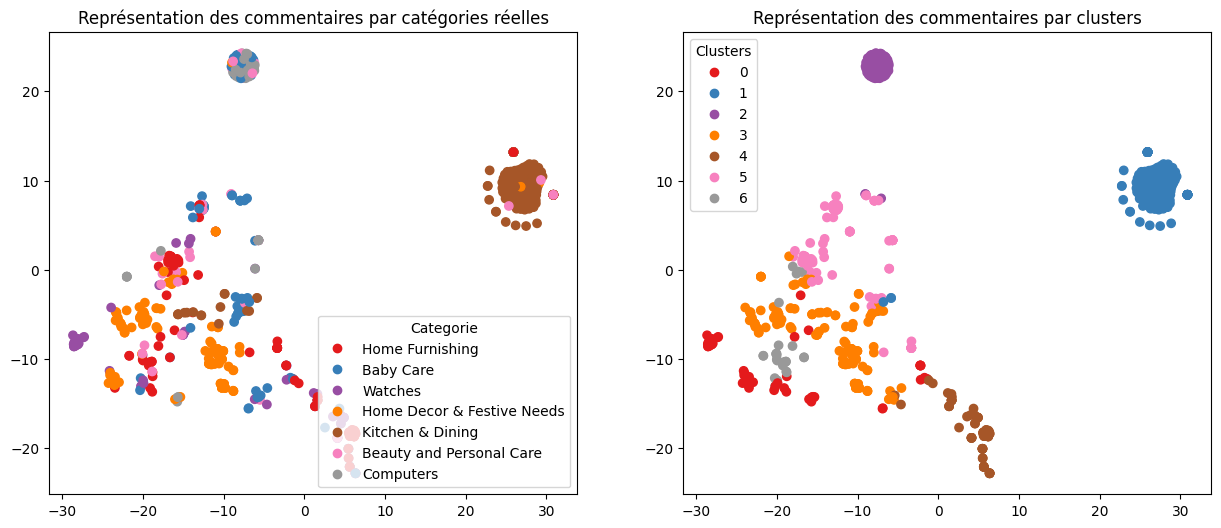

ARI :  0.4627


In [ ]:
ARI, X_tsne, labels, y_cat_ser = ARI_fct(glove["product_name"])
TSNE_visu_fct(X_tsne, y_cat_ser.tolist(), labels, ARI)

Il existe une autre solution que de prendre la moyenne des embeddings.<br>
Nous allons utiliser une ponderation moyenne des word vectors d'un commentaire et ensuite effectué une PCA sur cet nouvel feature avant de l'envoyer au KMeans.<br>

In [ ]:
# Make a weighted average of the word2vec embeddings
def weighted_average_word_vectors(words, word_to_vec_map):
    words = words.split()
    result = np.zeros(word_to_vec_map["hello"].shape)
    total_weight = 0
    for word in words:
        if word in word_to_vec_map:
            result += word_to_vec_map[word]
            total_weight += 1
    if total_weight == 0:
        return result
    return result / total_weight


In [ ]:
weighted_embeddings = dict()
for option in options:
    weighted_embeddings[option] = flipkart_filtered[option].apply(
        lambda x: weighted_average_word_vectors(x, word_to_vec_map)
    )

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Create a DataFrame with the weighted embeddings
for option in options:
    print(f"WEIGHTED {option}: ")
    print("--------")
    ARI, X_tsne, labels = ARI_fct(pd.DataFrame(weighted_embeddings[option].tolist()))
    print("Non null values sample: ", len(labels))
    print()

WEIGHTED product_name: 
--------
ARI :  0.0212 time :  5.0


ValueError: too many values to unpack (expected 3)

# BERT

In [ ]:
# import tensorflow_hub as hub

from tensorflow.keras.layers import *

# Bert
import os

os.environ["TF_KERAS"] = "1"

In [ ]:
# install torch


In [ ]:
# Import BERT
from transformers import BertTokenizer

In [ ]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Tokenize the text column
tokenized = flipkart_filtered["text"].apply(
    lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="pt")
)

In [ ]:
# Create a list of the tokenized tensors
tokenized_tensors = [tensor["input_ids"] for tensor in tokenized]

In [ ]:
import tensorflow_hub as hub


In [ ]:
# Load pretrained bert_en_uncased_L-12_H-768_A-12/3

model = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")


In [ ]:
# Load the bert_en_uncased_L-12_H-768_A-12/3 tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
text_exemple = "he loves working with data. It works like a charm at his work"

In [ ]:
# Preprocess the text with AutoTokenizer
text_preprocessed = tokenizer(
    text_exemple, padding=True, truncation=True, return_tensors="tf"
)

In [ ]:
type(text_preprocessed)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
text_preprocessed.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# Rename the keys with 'input_word_ids', 'input_mask' and 'input_type_ids'
text_preprocessed = {
    new_key: text_preprocessed[key]
    for key, new_key in zip(
        ["input_ids", "attention_mask", "token_type_ids"],
        ["input_word_ids", "input_mask", "input_type_ids"],
    )
}

In [ ]:
model(text_preprocessed)

{'pooled_output': <tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[-0.8115362 , -0.43281254, -0.8407893 ,  0.6736862 ,  0.25930652,
         -0.15918832,  0.80316085,  0.395319  , -0.60529697, -0.9999533 ,
         -0.1440674 ,  0.74857247,  0.9808339 ,  0.43200144,  0.89965   ,
         -0.5881434 , -0.1741608 , -0.6108952 ,  0.26124337, -0.05552725,
          0.7695719 ,  0.9998587 ,  0.23705362,  0.3294831 ,  0.4991836 ,
          0.8945839 , -0.6643711 ,  0.9050723 ,  0.9432497 ,  0.75134546,
         -0.62738633,  0.29033208, -0.98952585, -0.22210148, -0.85258085,
         -0.98485917,  0.47806135, -0.5897473 , -0.16911384, -0.05109132,
         -0.84457606,  0.42141047,  0.99988556, -0.80680716,  0.45777485,
         -0.32805568, -0.99999774,  0.29927924, -0.834642  ,  0.59672356,
          0.6314274 ,  0.35424152,  0.21421577,  0.40874404,  0.4602158 ,
          0.14649184, -0.13518348,  0.07417732, -0.2371627 , -0.56410396,
         -0.61290586,  0.43653405, -0.528765

In [ ]:
# Tokenize the text column
bert_tokens = flipkart_filtered["text"].apply(
    lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="tf")
)

In [ ]:
bert_tokens[5].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# Create a list of the tokenized tensors
bert_tensors = bert_tokens.tolist()

# Map the keys in each tensor to 'input_word_ids', 'input_mask' and 'input_type_ids'
bert_tensors = [
    {
        new_key: tensor[key]
        for key, new_key in zip(
            ["input_ids", "attention_mask", "token_type_ids"],
            ["input_word_ids", "input_mask", "input_type_ids"],
        )
    }
    for tensor in bert_tensors
]

In [ ]:
bert_vectors = []

# for each tensor in the bert_tensors list, compute the embeddings with the BERT model
for tensor in bert_tensors:
    embeddings = model(tensor)
    bert_vectors.append(embeddings["pooled_output"].numpy().ravel())

In [ ]:
# Unpack the list into a DataFrame
bert_df = pd.DataFrame(
    bert_vectors,
    index=flipkart_filtered.index,
    columns=[f"bert_{i}" for i in range(768)],
)

In [ ]:
print("BERT: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(bert_df)

BERT: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.0665 time :  18.0


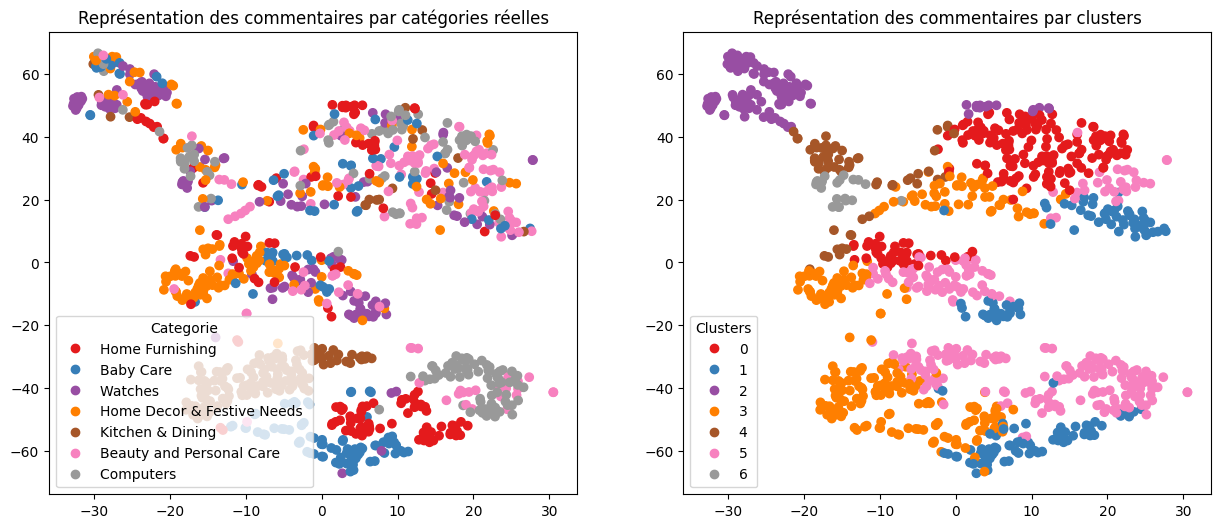

ARI :  0.0665


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = TFRobertaModel.from_pretrained("roberta-base")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors="tf")
output = model(encoded_input)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Tokenize the text column
roberta_tokens = flipkart_filtered["text"].apply(
    lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="tf")
)

In [ ]:
roberta_output = roberta_tokens.apply(lambda x: model(x))

In [ ]:
roberta_output[0].keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
# for each tensor in the bert_tensors list, compute the embeddings with the BERT model
roberta_vectors = []
for output in roberta_output:
    roberta_vectors.append(output["pooler_output"].numpy().ravel())

In [ ]:
# Unpack the list into a DataFrame
roberta_df = pd.DataFrame(
    roberta_vectors,
    index=flipkart_filtered.index,
    columns=[f"bert_{i}" for i in range(768)],
)

In [ ]:
print("ROBERTA: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(roberta_df)

ROBERTA: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.1345 time :  80.0


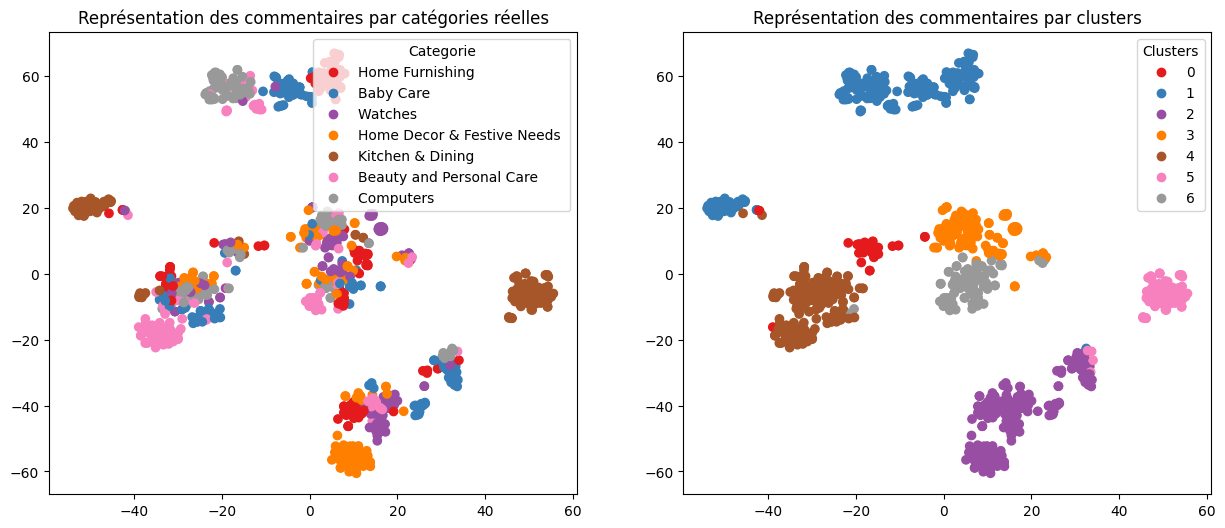

ARI :  0.1345


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE

Overview
The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. 

In [ ]:
import tensorflow_hub as hub

In [ ]:
# Load the Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Encode the text column with the Universal Sentence Encoder
use_embeddings = flipkart_filtered["text"].apply(lambda x: embed([x]).numpy().ravel())

In [ ]:
# Unpack the list into a DataFrame
use_df = pd.DataFrame(
    use_embeddings.tolist(),
    index=flipkart_filtered.index,
    columns=[f"use_{i}" for i in range(512)],
)

In [ ]:
print("USE: ")
print("--------")
ARI, X_tsne, labels = ARI_fct(use_df)

USE: 
--------


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3503 time :  71.0


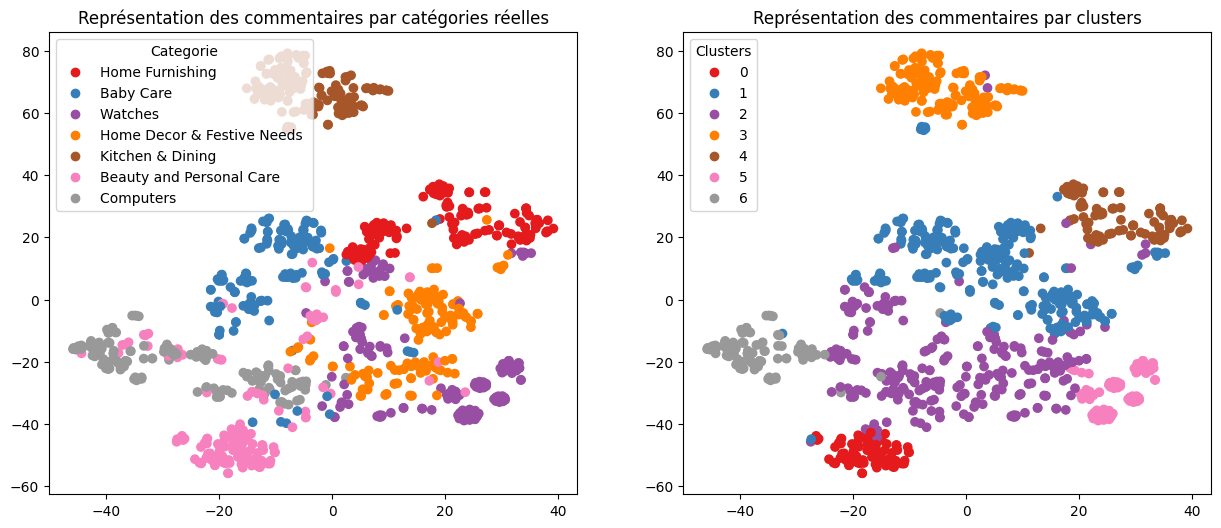

ARI :  0.3503


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)